# MNIST Image Classification with Keras

This notebook demonstrates how to implement a Convolutional Neural Network (CNN) on MNIST using Keras.

**Learning Objectives**
1. Understand how a convolutional operation works.
2. Understand how to build a CNN for image classification.
3. Visualize learned features from a CNN to understand the CNN structure.

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Markdown, display
from keras import layers, models

2025-08-08 21:06:59.559070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754687219.584133  827668 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754687219.591277  827668 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Visualizing the Convolutional Operation

A **convolution** is a fundamental mathematical operation in image processing. It involves applying a small matrix of numbers, called a **kernel** or **filter**, to an input image. The kernel slides over the image, performing an element-wise multiplication with the underlying pixels and then summing the results to produce a single output pixel. This process is repeated across the entire image to create a **feature map**, which highlights specific features like edges or textures.

In this section, we'll see this in action using a simple example. We'll use a standard MNIST image and apply two well-known filters—the Sobel X and Sobel Y kernels—to detect horizontal and vertical edges.


The Sobel kernels are designed to highlight directional changes in pixel intensity, which correspond to edges. The Sobel X kernel detects horizontal edges, while the Sobel Y kernel detects vertical edges.


After applying these kernels to the image, the output feature maps clearly show the detected edges, with the horizontal edges highlighted by the Sobel X kernel and the vertical edges by the Sobel Y kernel. This demonstrates how a simple convolutional operation can extract meaningful features from an image.



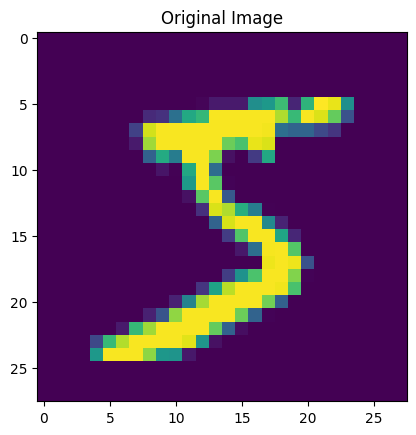

In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Select a single image
image = x_train[0].astype("float32")
plt.imshow(image)
plt.title("Original Image")
plt.show()

Now, let's define two Sobel kernels: one for detecting horizontal edges and one for detecting vertical edges.

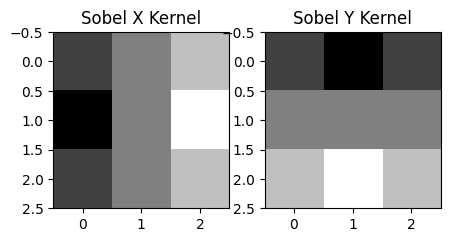

In [4]:
# fmt: off
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

sobel_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
], dtype=np.float32)
# fmt: on

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1, title="Sobel X Kernel")
plt.imshow(sobel_x, cmap="gray")
plt.subplot(1, 2, 2, title="Sobel Y Kernel")
plt.imshow(
    sobel_y,
    cmap="gray",
)
plt.show()

Next, we will apply these kernels to our image using a `Conv2D` layer. We will create two separate layers, one for each kernel.

In [5]:
image_reshaped = image.reshape(1, 28, 28, 1)
sobel_x_reshaped = sobel_x.reshape(3, 3, 1, 1)
sobel_y_reshaped = sobel_y.reshape(3, 3, 1, 1)

# Create Conv2D layers
conv_x = layers.Conv2D(1, (3, 3), use_bias=False, padding="valid")
conv_y = layers.Conv2D(1, (3, 3), use_bias=False, padding="valid")

conv_x.build(input_shape=(1, 28, 28, 1))
conv_y.build(input_shape=(1, 28, 28, 1))

conv_x.set_weights([sobel_x_reshaped])
conv_y.set_weights([sobel_y_reshaped])

# Apply the convolutions
output_x = conv_x(image_reshaped)
output_y = conv_y(image_reshaped)

I0000 00:00:1754687223.669981  827668 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 721 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754687224.938873  827668 cuda_dnn.cc:529] Loaded cuDNN version 90300


Finally, let's visualize the results. The feature maps show the detected horizontal and vertical edges.

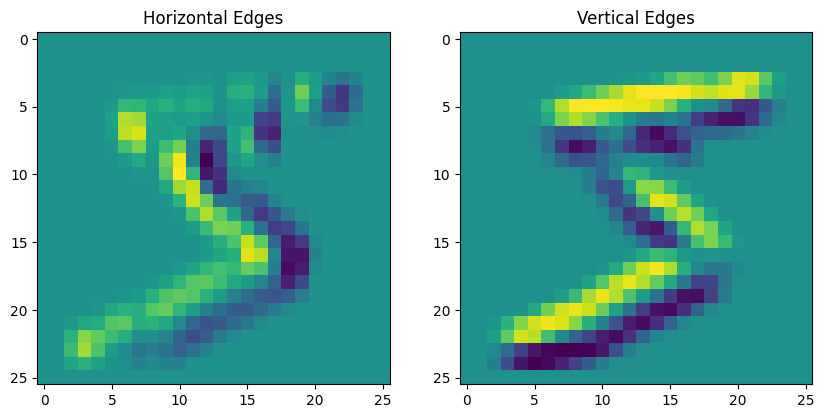

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(output_x.numpy().reshape(26, 26))
plt.title("Horizontal Edges")
plt.subplot(1, 2, 2)
plt.imshow(output_y.numpy().reshape(26, 26))
plt.title("Vertical Edges")
plt.show()

## Building and Training a Convolutional Neural Network (CNN)

A **Convolutional Neural Network (CNN)** is a type of deep learning model that excels at processing and classifying images. It's built with layers that automatically learn to extract relevant features from the input data. The key idea is that the network learns a hierarchy of features: simple features like edges in early layers, and more complex features like shapes and objects in deeper layers.

### Preprocessing the Data

Before feeding our MNIST images into the CNN, we need to prepare the data. The two main steps are:

1.  **Scaling**: The pixel values of the MNIST images range from 0 to 255. We normalize these values by dividing by 255.0 to scale them into the range of 0 to 1. This helps the model to train more efficiently.

2.  **One-Hot Encoding**: The image labels are single integers (0-9). We convert them into a **one-hot encoded vector**. For example, the label `5` becomes a vector `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`, where only the index corresponding to the correct digit is marked with a 1. This is a common practice for multi-class classification problems.

In [7]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

### Model Architecture

Our CNN is a sequential model composed of several layers. The core idea is to progressively extract and refine features from the images before making a final classification.

The architecture consists of:
* **Convolutional Layers (`Conv2D`)**: These layers apply filters to the input, learning to detect features. We use four of these layers with increasing numbers of filters (16, 32, and 64) to learn a richer hierarchy of features. The `relu` activation function is used to introduce non-linearity, allowing the model to learn more complex relationships.
* **Max Pooling Layers (`MaxPooling2D`)**: These layers follow the convolutional layers. They downsample the feature maps by taking the maximum value in a small window, which helps to reduce the spatial dimensions, computational cost, and prevent overfitting.
* **Flatten Layer**: This layer reshapes the 2D feature maps into a single 1D vector. This is a necessary step to connect the convolutional part of the network to the dense classification layers.
* **Dense Layers**: These are standard fully connected neural network layers. The first dense layer with 64 neurons processes the features from the flatten layer. The final dense layer with 10 neurons (one for each digit) uses a `softmax` activation function to output a probability distribution, indicating the model's confidence for each possible digit.

The model summary below shows the output shape and parameter count for each layer in the network.


In [8]:
model = models.Sequential(
    [
        layers.Conv2D(
            16,
            (3, 3),
            activation="relu",
            padding="same",
            input_shape=(28, 28, 1),
            name="Conv2D_1",
        ),
        layers.MaxPooling2D((2, 2), name="MaxPooling2D_1"),
        layers.Conv2D(
            32, (3, 3), activation="relu", padding="same", name="Conv2D_2"
        ),
        layers.MaxPooling2D((2, 2), name="MaxPooling2D_2"),
        layers.Conv2D(
            64, (3, 3), activation="relu", padding="same", name="Conv2D_3"
        ),
        layers.MaxPooling2D((2, 2), name="MaxPooling2D_3"),
        layers.Conv2D(
            64, (3, 3), activation="relu", padding="same", name="Conv2D_4"
        ),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_1 (MaxPooling2D)   │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_2 (MaxPooling2D)   │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_3 (MaxPooling2D)   │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,802 (382.04 KB)

 Trainable params: 97,802 (382.04 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Now we will train our model on the MNIST dataset. We will use a batch size of 128 and train for 10 epochs. An epoch is one complete pass through the entire training dataset. The batch size is the number of samples that will be propagated through the network at one time.

In [9]:
history = model.fit(
    x_train, y_train, epochs=10, batch_size=128, validation_split=0.2
)

Epoch 1/10


I0000 00:00:1754687227.490037  827754 service.cc:148] XLA service 0x7f20d400fd60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754687227.490071  827754 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


 40/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3264 - loss: 1.9416

I0000 00:00:1754687229.508231  827754 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7660 - loss: 0.7132 - val_accuracy: 0.9740 - val_loss: 0.0871
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9761 - loss: 0.0773 - val_accuracy: 0.9847 - val_loss: 0.0546
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9835 - loss: 0.0507 - val_accuracy: 0.9862 - val_loss: 0.0462
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9892 - loss: 0.0348 - val_accuracy: 0.9889 - val_loss: 0.0396
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9889 - loss: 0.0315 - val_accuracy: 0.9883 - val_loss: 0.0416
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9934 - loss: 0.0218 - val_accuracy: 0.9890 - val_loss: 0.0366
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9936 - loss: 0.0189 - val_accuracy: 0.9899 - val_loss: 0.0348
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9948 - loss: 0.0161 - val_accuracy: 0.9902 - val_

### Evaluate the Model

Now that we have trained our model, we need to evaluate its performance on the test data. We will use the accuracy metric to evaluate the model. Accuracy is the percentage of correctly classified images.

### Evaluate the Model

After training, we evaluate the model's performance on a separate test dataset that it has never seen before. The accuracy metric tells us the percentage of test images that the model correctly classified.

In [10]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9875 - loss: 0.0418
Test accuracy: 0.9905999898910522


### Show Failed Cases

Despite its high accuracy, the model isn't perfect. Analyzing the misclassified images can offer insights into the model's limitations. Some of these errors might be due to ambiguous or poorly written digits that are difficult for both humans and AI to interpret.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


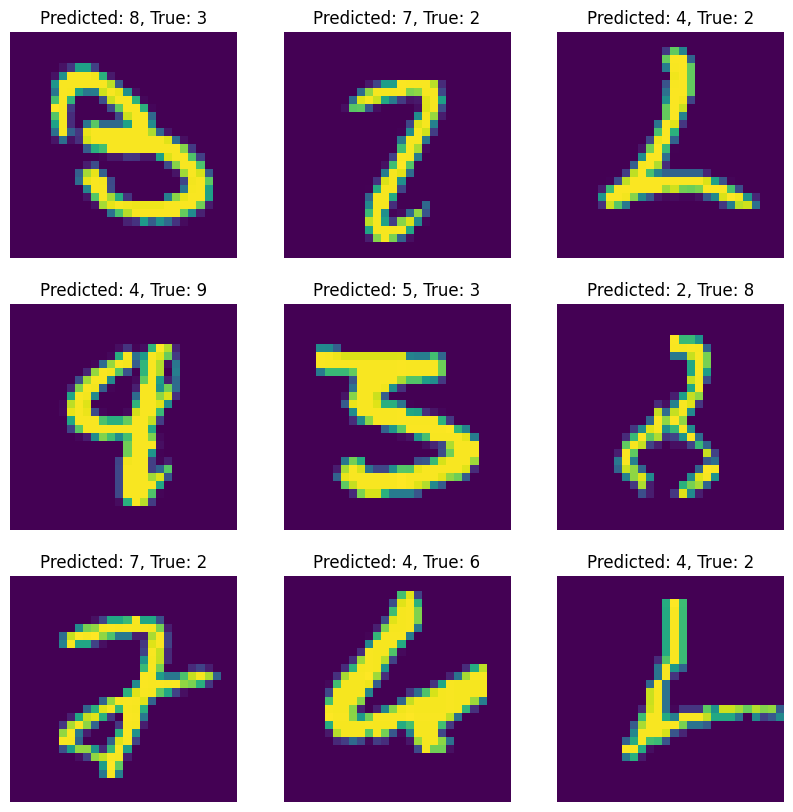

In [11]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

misclassified_indices = np.where(predicted_labels != true_labels)[0]

plt.figure(figsize=(10, 10))
for i, index in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.title(
        f"Predicted: {predicted_labels[index]}, True: {true_labels[index]}"
    )
    plt.axis("off")
plt.show()

## Analyzing CNN

### Visualize Learned Kernels

The filters inside a convolutional layer are what the model learns to identify specific features. By visualizing the weights of these filters, we can get a sense of what the model is looking for at each stage.

Here, we display the 16 filters from the first convolutional layer. Each square represents a 3x3 filter. You can see that the filters have learned to detect basic features such as various oriented edges and simple patterns. These basic features are the building blocks for the more complex features learned in subsequent layers.


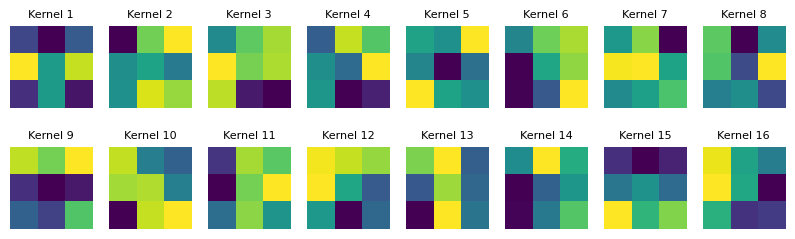

In [12]:
first_conv_layer = model.layers[0]
weights = first_conv_layer.get_weights()[0]

plt.figure(figsize=(10, 6))
for i in range(weights.shape[-1]):
    plt.subplot(4, 8, i + 1)
    plt.title(f"Kernel {i + 1}", fontsize=8)
    plt.imshow(weights[:, :, 0, i])
    plt.axis("off")
plt.show()

### Visualizing Feature Maps

As data passes through a CNN, each layer transforms the input into feature maps. These maps highlight the presence of features that the filters in that layer have learned to detect. Visualizing these maps for different layers helps us understand how the network progressively builds up a more abstract representation of the input image.

- **First Convolutional Layer**: The feature maps from this layer show the presence of simple features like edges and corners, as detected by the learned kernels.
- **Second Convolutional Layer**: These maps are the result of applying filters to the outputs of the first layer. They show more complex features, which are combinations of the simpler features detected in the previous layer. This demonstrates the hierarchical nature of feature learning in CNNs.
- **Third and Fourth Convolutional Layers**: As we go deeper, the feature maps become more abstract and less directly interpretable to the human eye. They represent higher-level features and patterns that are essential for the final classification task.

In [13]:
def visualize_feature_map(activation):
    num_channel = activation.shape[-1]
    plt.figure(figsize=(10, num_channel // 8 * 1.5))
    for i in range(num_channel):
        plt.subplot(num_channel // 8, 8, i + 1)
        plt.title(f"Channel {i + 1}", fontsize=8)
        plt.imshow(activation[0, :, :, i], vmax=np.max(activation))
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


## Input Image, shape: (28, 28, 1)

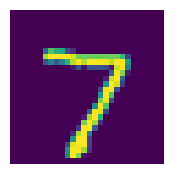

## Conv2D_1, output shape: (28, 28, 16)

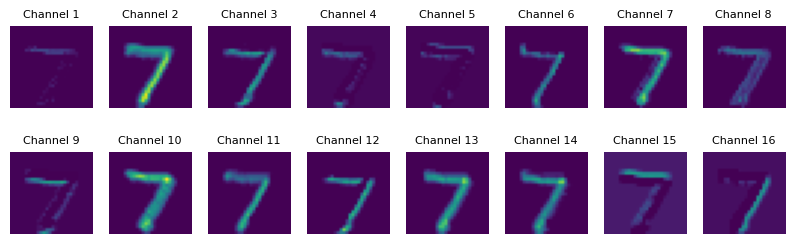

## Conv2D_2, output shape: (14, 14, 32)

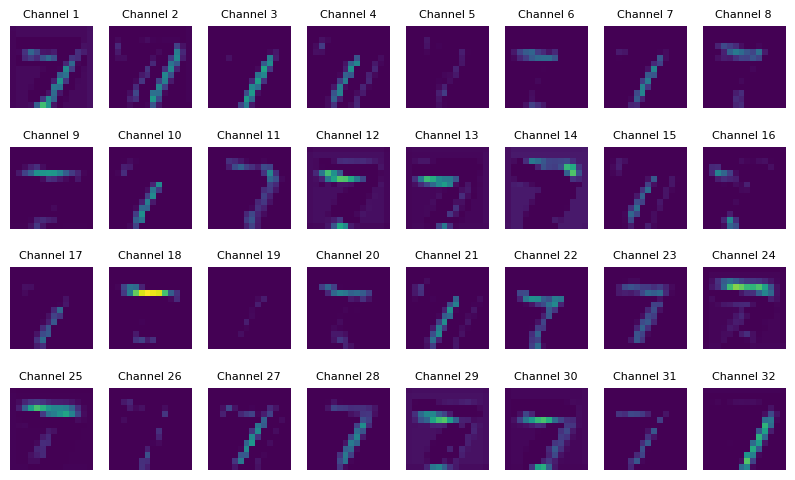

## Conv2D_3, output shape: (7, 7, 64)

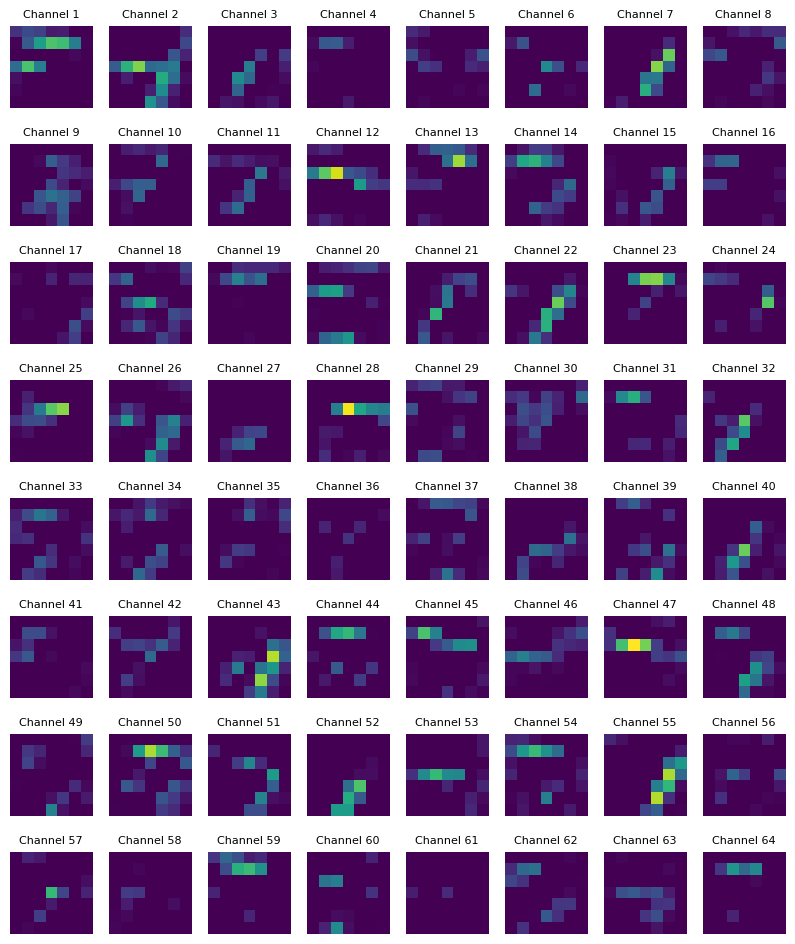

## Conv2D_4, output shape: (3, 3, 64)

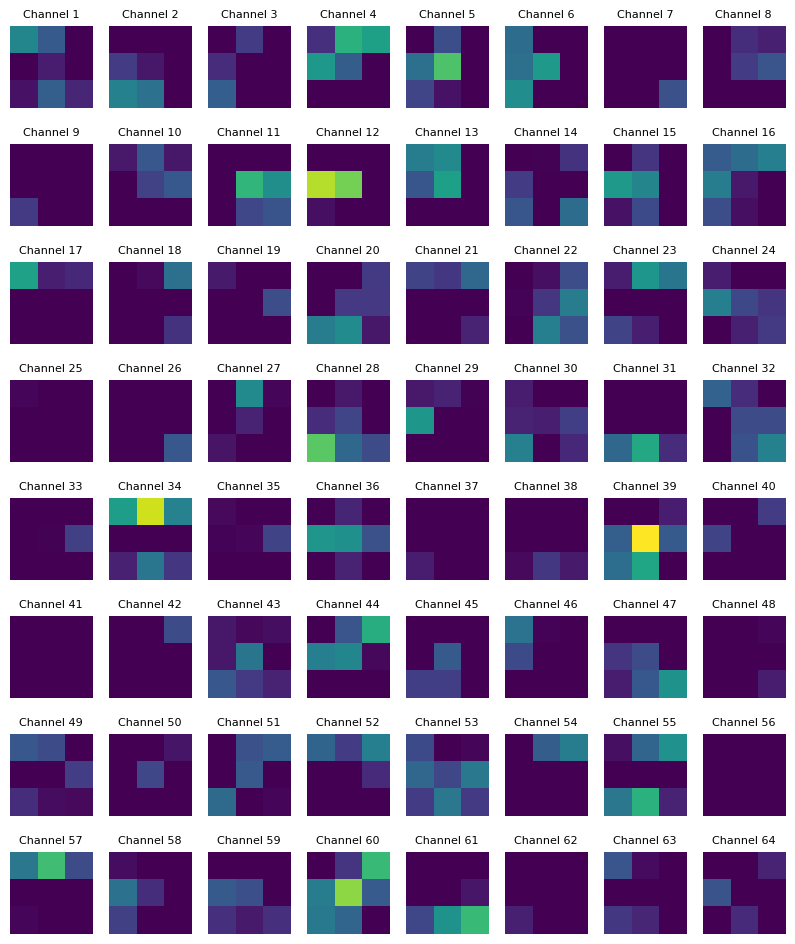

In [14]:
TEST_IMG_INDEX = 0  # Change this index to check differnet images
CONV_ONLY = True  # False to visualize MaxPooling too

layers = model.layers[0:7:2] if CONV_ONLY else model.layers[:7]
outputs = [layer.output for layer in layers]
activation_model = models.Model(inputs=model.inputs, outputs=outputs)

test_image = x_test[TEST_IMG_INDEX].reshape(1, 28, 28, 1)
activations = activation_model.predict(test_image)

display(Markdown(f"## Input Image, shape: {x_test[TEST_IMG_INDEX].shape}"))
plt.figure(figsize=(2, 2))
plt.imshow(x_test[TEST_IMG_INDEX])
plt.axis("off")
plt.show()

for i, activation in enumerate(activations):
    display(
        Markdown(f"## {layers[i].name}, output shape: {activation.shape[1:]}")
    )
    visualize_feature_map(activation)

The visualizations illustrate how the CNN transforms the raw image pixels into a set of features, which contains highly abstruct signals about class information, enabling a correct classification.

Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.